In [1]:
### Imports ###

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

# Exoplanet data packages
import lightkurve as lk

# Dynamic nested sampling
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler
from dynesty import plotting as dyplot

# Library of custom functions
import TESSPhaseCurve_lib as TPC

# Matplotlib settings
fontweight = 300
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

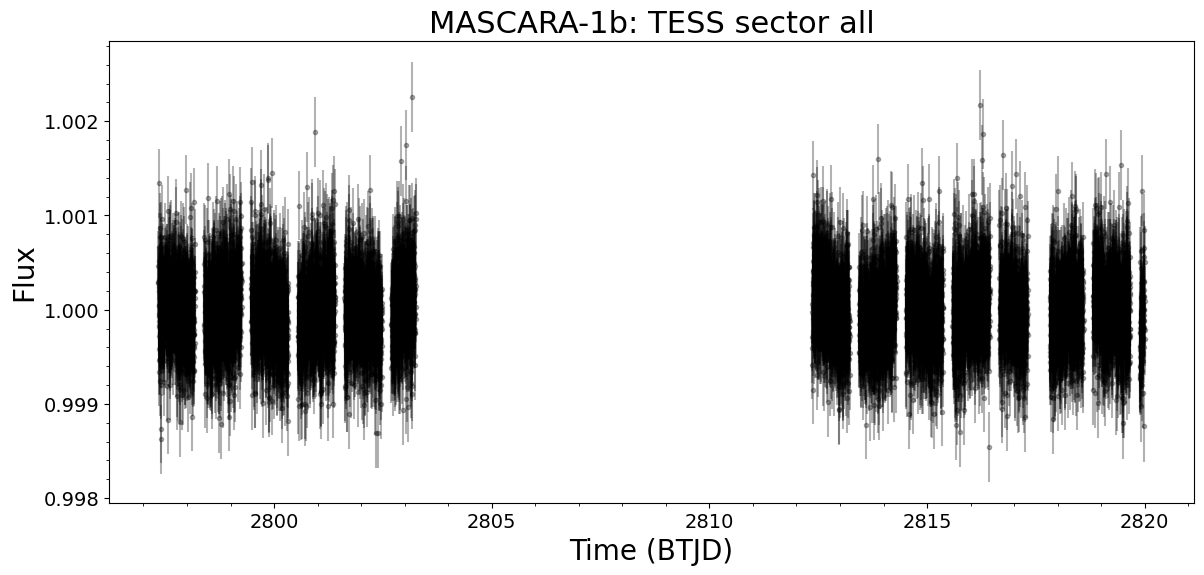

In [2]:
### Read in data ###

planet_name = 'MASCARA-1b'
df = pd.read_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv')
sectors = np.unique(df.sector)
sector_ind = 'all' # set between 0 and len(sectors) to select an individual sector, set to 'all' for all sectors

if sector_ind == 'all':
    sector = 'all'
    time = np.array(df.time)
    flux = np.array(df.flux)
    flux_err = np.array(df.flux_err)
else:
    sector = sectors[sector_ind]
    sector_bool = df.sector == sector
    time = np.array(df.time)[sector_bool]
    flux = np.array(df.flux)[sector_bool]
    flux_err = np.array(df.flux_err)[sector_bool]        

# Store data as a Lightkurve object to make it easier for phase-folding
lc_data = {'time': time,
           'flux': flux,
           'flux_err': flux_err
          }
lc_data = lk.LightCurve(lc_data)

# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(time, flux, flux_err, fmt='.', color='k', alpha=0.3)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': TESS sector '+str(sector))
plt.show()

In [3]:
### Set up Bayesian framework ###

# Names of all the model parameters
labels = [r'$t_0$', r'$P$', r'$f_p$', r'$\delta$',
          r'$A_1$', r'$B_1$', r'$A_2$', r'$B_2$', r'$A_3$', r'$B_3$']
ndim = len(labels) # number of model parameters

# Define an array of booleans that describe whether the priors will be uniform (True) or Gaussian (False) in order
priors_bool = np.array([True]*ndim)
priors_bool[0:2] = np.array([False]*2) # Setting the first two parameters to have Gaussian priors

# Define pairs of values that describe the priors for each parameter in order
priors = np.array([[1833.488151, 0.00014], # t_0, Gaussian prior from literature
                   [2.14877381, 0.00000087], # P, Gaussian prior from literature
                   [0, 2e-3], # f_p, uniform prior
                   [-np.pi/4, np.pi/4], # delta, uniform prior
                   [-1e-2, 1e-2], # A_1, uniform prior
                   [-1e-3, 1e-3], # B_1, uniform prior
                   [-1e-3, 1e-3], # A_2, uniform prior
                   [-1e-3, 1e-3], # B_2, uniform prior
                   [-1e-3, 1e-3], # A_3, uniform prior
                   [-1e-3, 1e-3]]) # B_3, uniform prior

In [4]:
### Likelihood function ###

loglike_args = (lc_data.time.value, lc_data.flux.value, lc_data.flux_err.value,
                TPC.psi_tot_func_no_pulse) # loglike function arguments
ptform_args = (priors, priors_bool) # prior_transform function arguments

In [5]:
### Perform nested sampling ###

# Initialize the sampler that will search the parameter space
sampler = DynamicNestedSampler(TPC.loglike, TPC.prior_transform, ndim,
                        logl_args=loglike_args, ptform_args=ptform_args)

# Run the sampler; we define convergence when the estimated contribution of the remaining prior volume to the
# total evidence falls below 1%
filename_root =''.join(planet_name.split())+'_sector'+str(sector) # filename at which to save progress
sampler.run_nested(dlogz_init=0.01, maxiter=100000, checkpoint_file=filename_root+'.save', print_progress=True)

# Save the results from running the sampler
res = sampler.results

# Extract the 50th percentile parameter samples as best fit parameters
params_best = np.array([dynesty.utils.quantile(res.samples[:, i], 0.50, 
                                              weights=res.importance_weights())[0] for i in range(ndim)])

4990it [12:57,  5.59it/s, batch: 0 | bound: 44 | nc: 30 | ncall: 114384 | eff(%):  4.344 | loglstar:   -inf < 54298.476 <    inf | logz: 54282.385 +/-  0.177 | dlogz: 1918.798 >  0.010]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

24922it [50:15,  8.94it/s, batch: 6 | bound: 10 | nc: 30 | ncall: 697844 | eff(%):  3.496 | loglstar: 56514.401 < 56516.904 < 56520.244 | logz: 56489.915 +/-  0.163 | stop:  1.045]     IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_lim

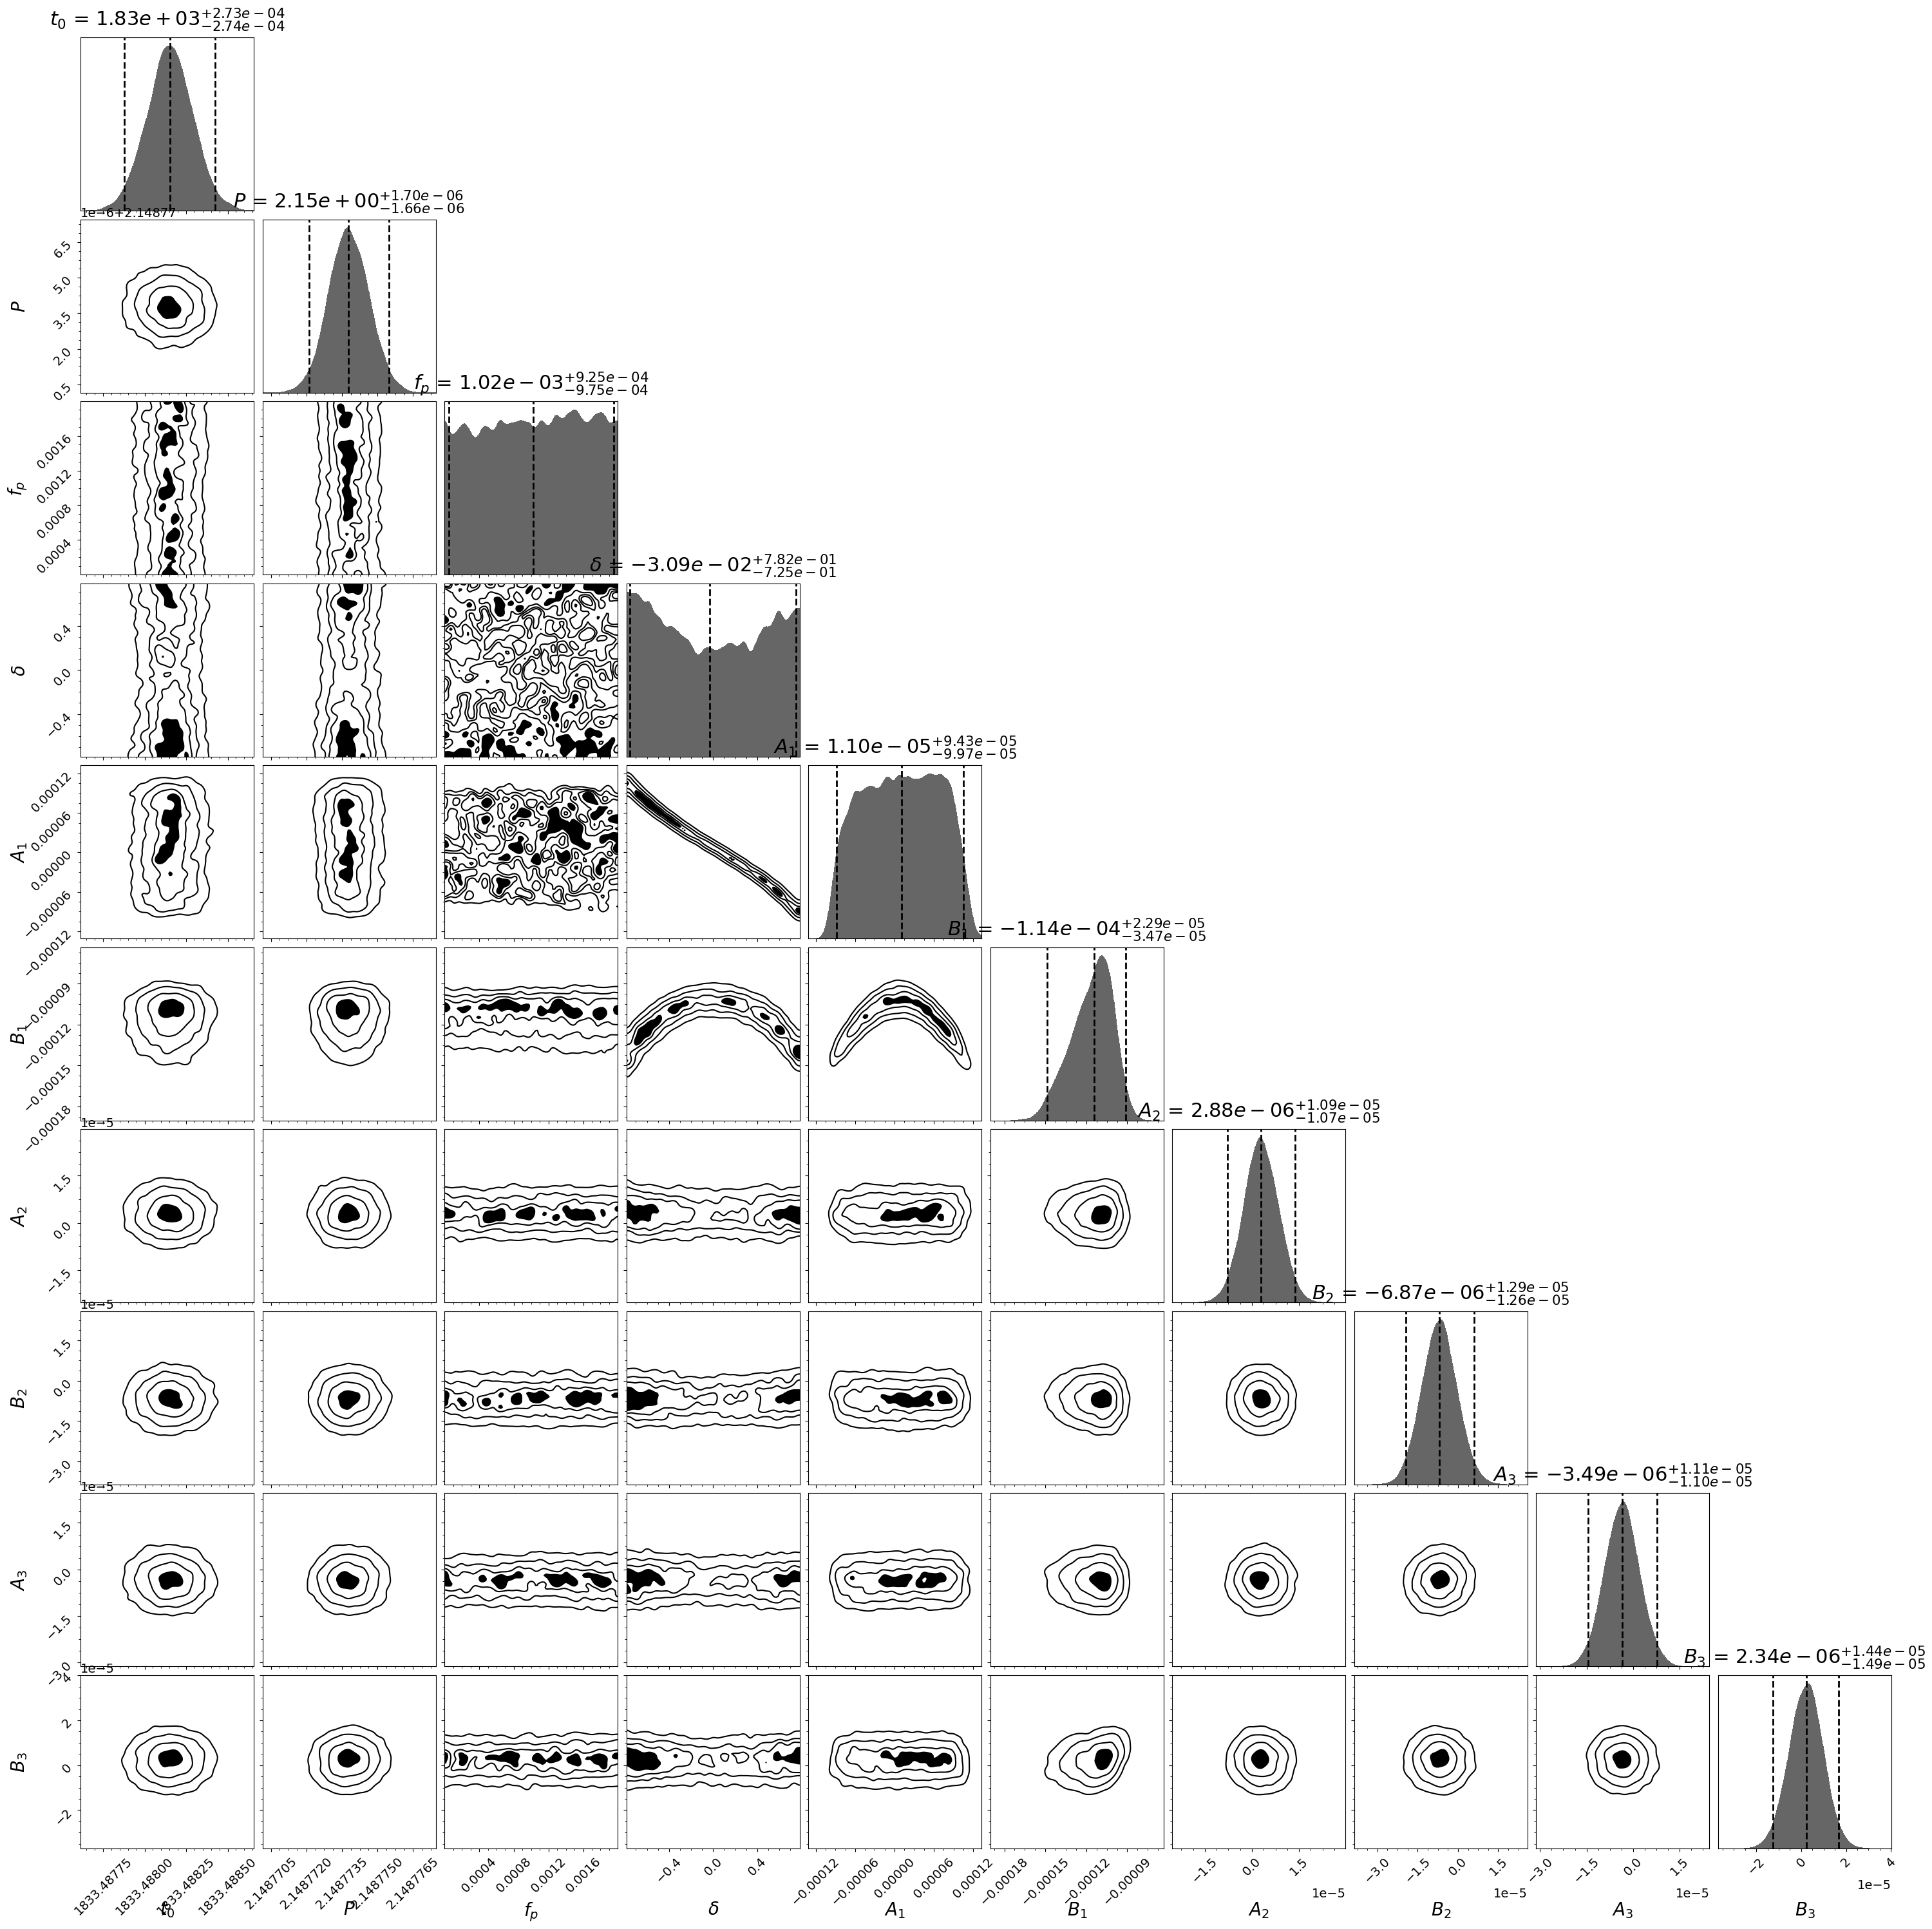

In [6]:
### Corner plot ###

truths = (2288.807775, 3.47410042, None, None, None, None, None, None, None, None)

fig, axes = dyplot.cornerplot(res, show_titles=True, title_fmt='0.2e',
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(30, 30)), truths=truths)

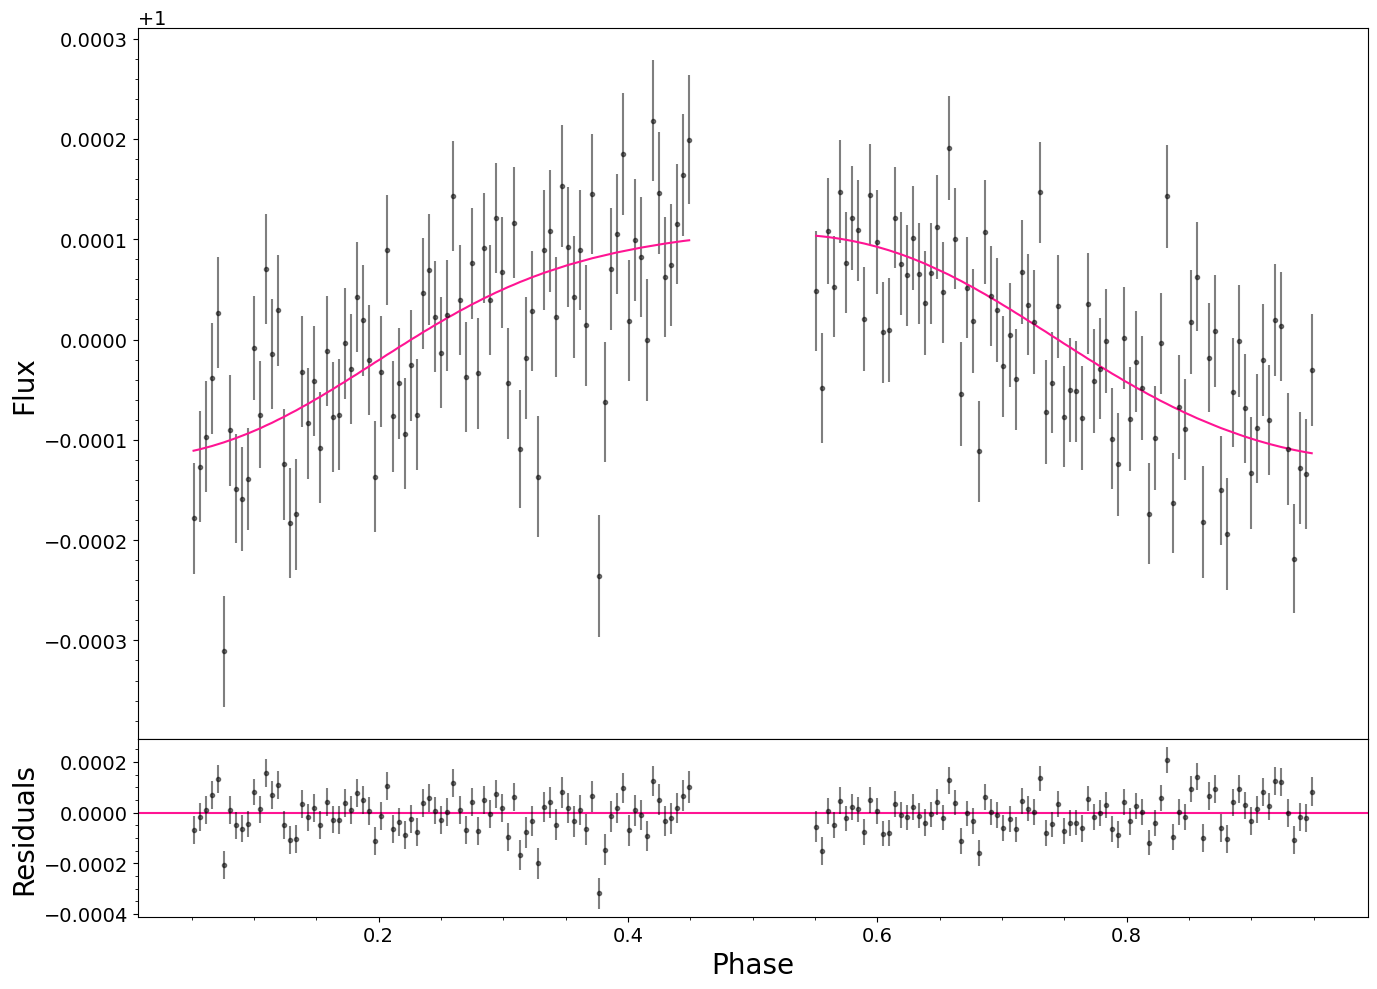

[ 1.83348815e+03  2.14877378e+00  1.02470218e-03 -3.08764495e-02
  1.10434134e-05 -1.14065121e-04  2.88068930e-06 -6.86953917e-06
 -3.49139334e-06  2.33829047e-06]


In [9]:
### Compute the model light curve ###

# Extract best-fit mid-transit time, planet orbital period, and delta
t_0_best, P_best, delta_best = params_best[0]*u.day, params_best[1]*u.day, params_best[6]

# Calculate model and assign to a Lightkurve object
model = TPC.psi_tot_func_no_pulse(params_best, lc_data.time.value)
lc_model = {'time': lc_data.time.value,
           'flux': model,
          }
lc_model = lk.LightCurve(lc_model)

# Phase fold and bin data and model
bin_width = (15*u.min).to(u.day)/P_best * u.day
lc_data_fold = TPC.fold_lk(lc_data, P_best, t_0_best)
lc_data_bin = lc_data_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)
lc_model_fold = TPC.fold_lk(lc_model, P_best, t_0_best)
lc_model_bin = lc_model_fold.bin(time_bin_size=bin_width, aggregate_func=np.nanmedian)

# Calculate the peak phase of the model
peak_phase = lc_model_bin.time.value[np.argmax(lc_model_bin.flux.value)]
# peak_phase = 0.5 - (delta_best * np.pi/180)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [4, 1], 'hspace': 0})

# Plot data and best fit model
ax1.errorbar(lc_data_bin.time.value, lc_data_bin.flux.value, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5)
ax1.plot(lc_model_bin.time.value, lc_model_bin.flux.value, color='deeppink')
ax1.set_ylabel('Flux')

# Plot residuals
residuals = lc_data_bin.flux.value - lc_model_bin.flux.value
ax2.errorbar(lc_data_bin.time.value, residuals, lc_data_bin.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=1)
ax2.axhline(0, color='deeppink', zorder=0)
ax2.set_xlabel('Phase')
ax2.set_ylabel('Residuals')

# Formatting
plt.tight_layout()
plt.show()

print(params_best)